In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =2e-20

nband = 120

ng =7

ng_refs = (/ 2 , 5 /) 

nref =2

nv = 1000

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

tsfc =257

vstar = 980

data w_diffuse
     &     /1.6 , 1.75 , 1.55 , 1.66,
     &     1.7 , 1.75 , 1.8/

data wgt
     &     /0.35 , 0.6 , 0.5 , 0.55,
     &     0.7 , 0.9 , 1.0/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

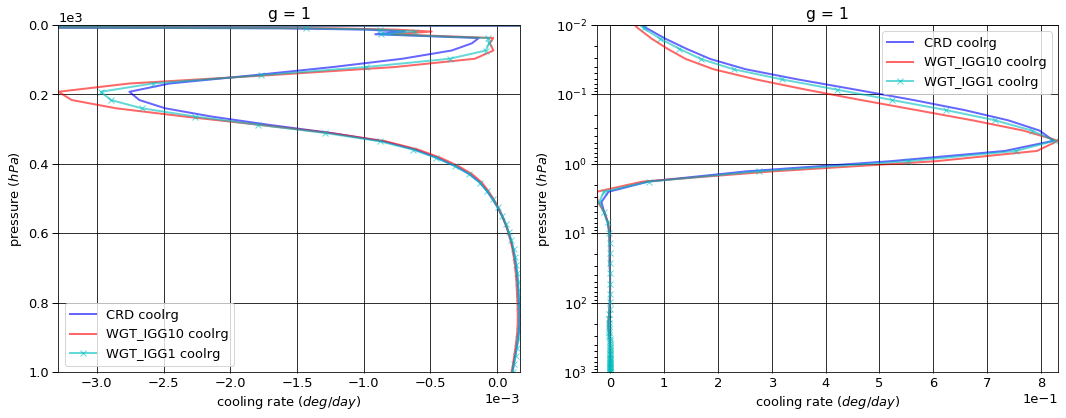

# Figure: cooling rate g-group 2

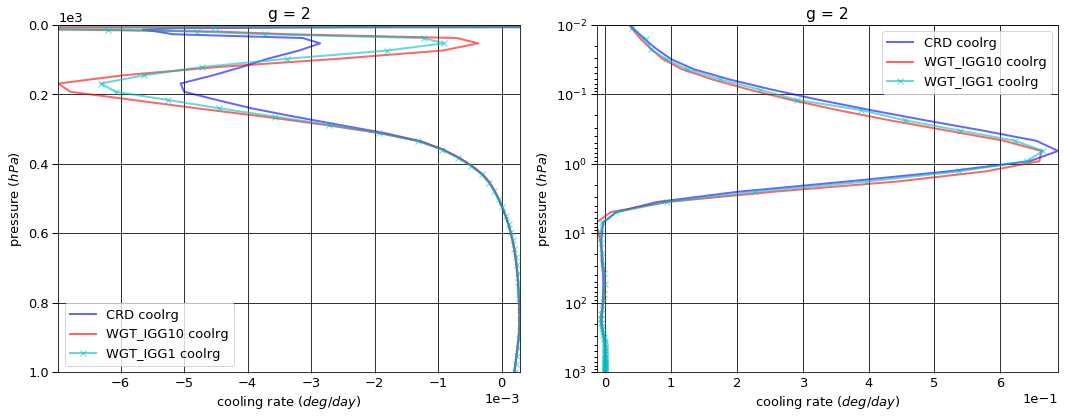

# Figure: cooling rate g-group 3

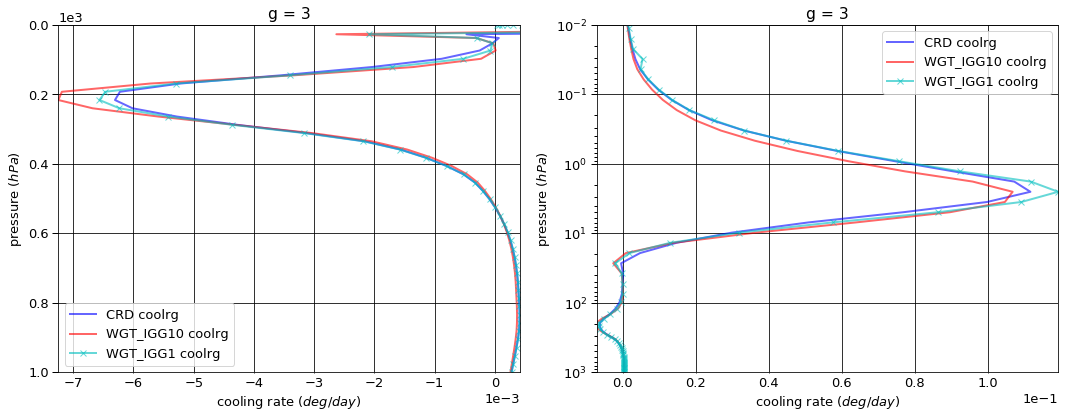

# Figure: cooling rate g-group 4

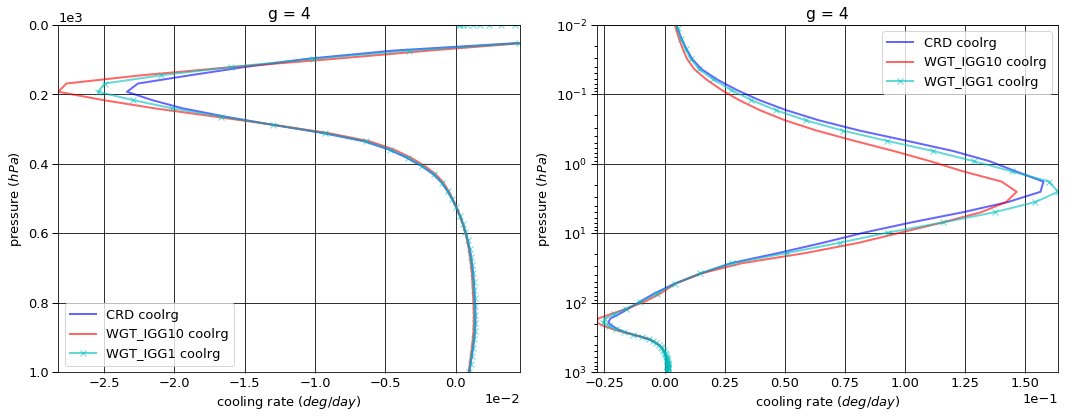

# Figure: cooling rate g-group 5

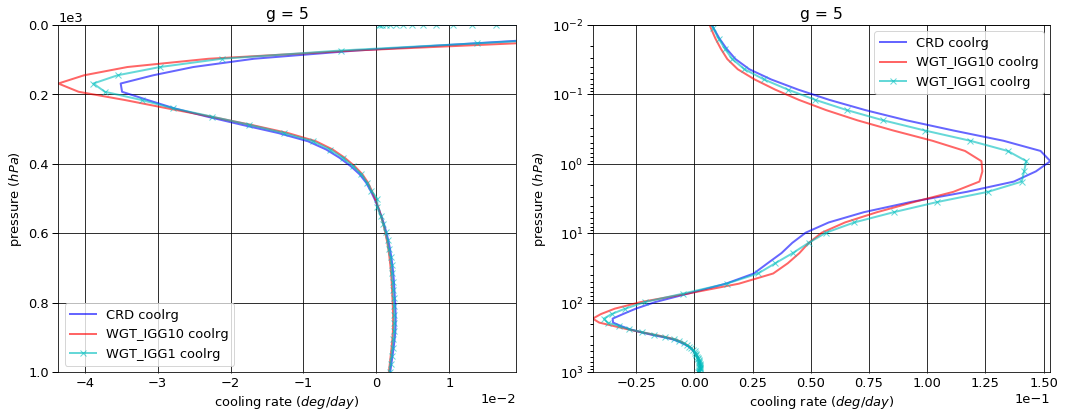

# Figure: cooling rate g-group 6

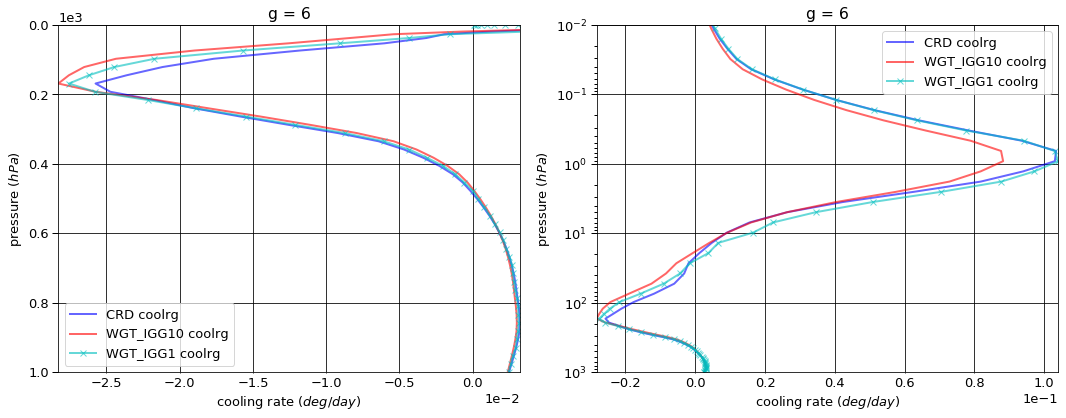

# Figure: cooling rate g-group 7

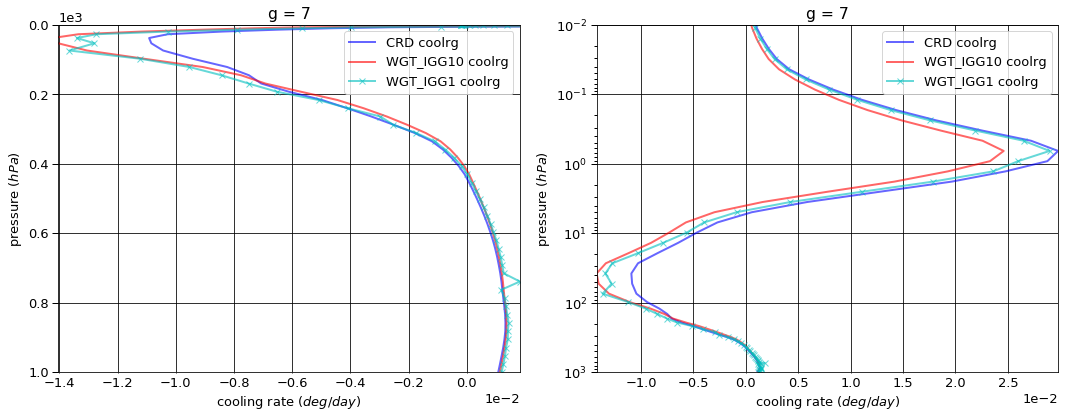

# Figure: cooling rate g-group total

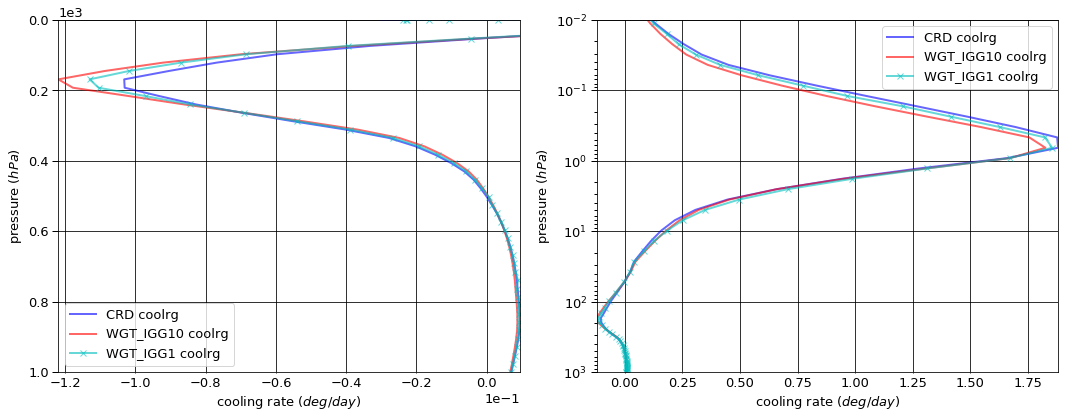

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.090674  0.000000 -0.090674
  1013.0   76    -0.105408  0.048977 -0.056431
2 0.0      1     -0.150210  0.000000 -0.150210
  1013.0   76    -0.234004  0.100441 -0.133563
3 0.0      1     -0.097518  0.000000 -0.097518
  1013.0   76    -0.238444  0.113794 -0.124649
4 0.0      1     -0.346250  0.000000 -0.346250
  1013.0   76    -0.990883  0.442448 -0.548435
5 0.0      1     -0.861406  0.000000 -0.861406
  1013.0   76    -2.136436  0.838107 -1.298328
6 0.0      1     -2.212266  0.000000 -2.212266
  1013.0   76    -3.560104  0.903194 -2.656911
7 0.0      1     -7.246585  0.000000 -7.246585
  1013.0   76    -7.786128  0.357543 -7.428584


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.092053  0.000000 -0.092053
  1013.0   76    -0.105408  0.047883 -0.057525
2 0.0      1     -0.152954  0.000000 -0.152954
  1013.0   76    -0.234004  0.100509 -0.133495
3 0.0      1     -0.097166  0.000000 -0.097166
  1013.0   76    -0.238444  0.110056 -0.128387
4 0.0      1     -0.339034  0.000000 -0.339034
  1013.0   76    -0.990883  0.434011 -0.556871
5 0.0      1     -0.773604  0.000000 -0.773604
  1013.0   76    -2.136436  0.852271 -1.284165
6 0.0      1     -2.069433  0.000000 -2.069433
  1013.0   76    -3.560104  0.961364 -2.598740
7 0.0      1     -7.201233  0.000000 -7.201233
  1013.0   76    -7.786128  0.380433 -7.405695


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.091266  0.000000 -0.091266
  1013.0   76    -0.105408  0.049204 -0.056203
2 0.0      1     -0.150522  0.000000 -0.150522
  1013.0   76    -0.234004  0.101357 -0.132647
3 0.0      1     -0.098967  0.000000 -0.098967
  1013.0   76    -0.238444  0.113938 -0.124505
4 0.0      1     -0.343168  0.000000 -0.343168
  1013.0   76    -0.990883  0.442162 -0.548721
5 0.0      1     -0.822058  0.000000 -0.822058
  1013.0   76    -2.136436  0.843766 -1.292670
6 0.0      1     -2.144720  0.000000 -2.144720
  1013.0   76    -3.560104  0.934048 -2.626056
7 0.0      1     -7.180573  0.000000 -7.180573
  1013.0   76    -7.786128  0.396217 -7.389910


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -1.378696e-03  0.000000 -0.001379
  1013.0   76     0.000000e+00 -0.001094 -0.001094
2 0.0      1     -2.743050e-03  0.000000 -0.002743
  1013.0   76     0.000000e+00  0.000068  0.000068
3 0.0      1      3.522510e-04  0.000000  0.000352
  1013.0   76     0.000000e+00 -0.003738 -0.003738
4 0.0      1      7.216480e-03  0.000000  0.007216
  1013.0   76     1.110223e-16 -0.008437 -0.008437
5 0.0      1      8.780190e-02  0.000000  0.087802
  1013.0   76     4.440892e-16  0.014164  0.014163
6 0.0      1      1.428329e-01  0.000000  0.142833
  1013.0   76     0.000000e+00  0.058170  0.058170
7 0.0      1      4.535220e-02  0.000000  0.045352
  1013.0   76     0.000000e+00  0.022889  0.022889


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -5.922350e-04  0.000000 -0.000592
  1013.0   76     0.000000e+00  0.000227  0.000227
2 0.0      1     -3.118900e-04  0.000000 -0.000312
  1013.0   76     0.000000e+00  0.000916  0.000916
3 0.0      1     -1.448293e-03  0.000000 -0.001448
  1013.0   76     0.000000e+00  0.000144  0.000144
4 0.0      1      3.082190e-03  0.000000  0.003082
  1013.0   76     1.110223e-16 -0.000286 -0.000286
5 0.0      1      3.934830e-02  0.000000  0.039348
  1013.0   76     4.440892e-16  0.005659  0.005659
6 0.0      1      6.754580e-02  0.000000  0.067546
  1013.0   76     0.000000e+00  0.030854  0.030854
7 0.0      1      6.601200e-02  0.000000  0.066012
  1013.0   76     0.000000e+00  0.038674  0.038674

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.024231
  1001.112500 75     0.000113
2 0.000312    1     -0.004294
  1001.112500 75     0.000199
3 0.000312    1      0.000009
  1001.112500 75     0.000275
4 0.000312    1      0.000108
  1001.112500 75     0.000975
5 0.000312    1      0.000161
  1001.112500 75     0.001887
6 0.000312    1     -0.000037
  1001.112500 75     0.002466
7 0.000312    1     -0.000142
  1001.112500 75     0.001075


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.015947
  1001.112500 75     0.000109
2 0.000312    1     -0.001585
  1001.112500 75     0.000202
3 0.000312    1      0.000049
  1001.112500 75     0.000258
4 0.000312    1      0.000247
  1001.112500 75     0.000931
5 0.000312    1      0.000353
  1001.112500 75     0.001707
6 0.000312    1     -0.000015
  1001.112500 75     0.002384
7 0.000312    1     -0.000201
  1001.112500 75     0.001134


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.020317
  1001.112500 75     0.000115
2 0.000312    1     -0.002926
  1001.112500 75     0.000204
3 0.000312    1      0.000042
  1001.112500 75     0.000278
4 0.000312    1      0.000249
  1001.112500 75     0.000973
5 0.000312    1      0.000381
  1001.112500 75     0.001806
6 0.000312    1      0.000063
  1001.112500 75     0.002447
7 0.000312    1     -0.000180
  1001.112500 75     0.001191


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.008285
  1001.112500 75    -0.000004
2 0.000312    1      0.002708
  1001.112500 75     0.000004
3 0.000312    1      0.000040
  1001.112500 75    -0.000017
4 0.000312    1      0.000140
  1001.112500 75    -0.000044
5 0.000312    1      0.000192
  1001.112500 75    -0.000179
6 0.000312    1      0.000022
  1001.112500 75    -0.000082
7 0.000312    1     -0.000059
  1001.112500 75     0.000059


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.003914
  1001.112500 75     0.000002
2 0.000312    1      0.001368
  1001.112500 75     0.000006
3 0.000312    1      0.000033
  1001.112500 75     0.000004
4 0.000312    1      0.000142
  1001.112500 75    -0.000002
5 0.000312    1      0.000221
  1001.112500 75    -0.000080
6 0.000312    1      0.000100
  1001.112500 75    -0.000019
7 0.000312    1     -0.000038
  1001.112500 75     0.000116

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-11.004910,0.000000,-11.004910
1013.0,76,-15.051406,2.804505,-12.246902



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.725476,0.000000,-10.725476
1013.0,76,-15.051406,2.886527,-12.164880



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.831274,0.000000,-10.831274
1013.0,76,-15.051406,2.880693,-12.170713



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.279434,0.000000,0.279434
1013.0,76,0.000000,0.082022,0.082022



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.173636,0.000000,0.173636
1013.0,76,0.000000,0.076189,0.076189


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.028426
1001.112500,75,0.006989



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.017098
1001.112500,75,0.006726



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.022687
1001.112500,75,0.007016



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.011328
1001.112500,75,-0.000263



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.005739
1001.112500,75,0.000026


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.007008,0.007001
2,0.015458,0.015548
3,0.015917,0.015833
4,0.065800,0.065818
5,0.140908,0.141961
6,0.232192,0.236740
7,0.522717,0.517099


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.107750e-18
2,7.729691e-19
3,1.023108e-18
4,2.756166e-19
5,7.424874e-20
6,2.000197e-20
7,1.116904e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.107750e-18,NaN,0.007008,0.007001,0.007008,0.007001,1.0
2,7.729691e-19,0.151333,0.015458,0.015548,0.022467,0.022549,1.0
3,1.023108e-18,1.323608,0.015917,0.015833,0.038383,0.038382,50.0
4,2.756166e-19,0.269391,0.065800,0.065818,0.104183,0.104200,50.0
5,7.424874e-20,0.269391,0.140908,0.141961,0.245092,0.246161,50.0
6,2.000197e-20,0.269391,0.232192,0.236740,0.477283,0.482901,50.0
7,1.116904e-22,0.005584,0.522717,0.517099,1.000000,1.000000,50.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.250787e-17  9.588182e-18   1.304509  2.274770e-05
      2 0.000312     1.796219e-18  1.192162e-18   1.506690  3.333012e-06
      3 0.000312     3.035604e-20  2.833355e-20   1.071382  6.291443e-08
      4 0.000312     2.655817e-20  1.897402e-20   1.399712  4.962289e-08
      5 0.000312     1.960106e-20  8.456909e-21   2.317756  3.485630e-08
      6 0.000312     8.722625e-21  3.422940e-21   2.548285  1.756483e-08
      7 0.000312     1.378052e-21  5.114564e-23  26.943678  2.954505e-09
2     1 0.000750     1.246177e-17  9.587995e-18   1.299727  1.064533e-05
      2 0.000750     1.808238e-18  1.203457e-18   1.502537  1.573942e-06
      3 0.000750     3.109920e-20  2.900427e-20   1.072228  3.019785e-08
      4 0.000750     2.706655e-20  1.927190e-20   1.404457  2.367351e-08
      5 0.000750     1.996187e-20  8.550892e-21   2.334478  1.661899e-08
      6 0.000750     8.879892e-21  3.463330e-21   2.563975  8.378778e-09
      7 0.000750     1.398111e-21  5.180098e-23  26.990048  1.404909e-09
3     1 0.001052     1.236845e-17  9.585442e-18   1.290337  1.912729e-05
      2 0.001052     1.832357e-18  1.226149e-18   1.494400  2.879869e-06
      3 0.001052     3.256134e-20  3.031599e-20   1.074065  5.694744e-08
      4 0.001052     2.810144e-20  1.986680e-20   1.414492  4.419021e-08
      5 0.001052     2.070627e-20  8.740011e-21   2.369136  3.100434e-08
      6 0.001052     9.207863e-21  3.545251e-21   2.597239  1.565325e-08
      7 0.001052     1.440539e-21  5.308868e-23  27.134578  2.609367e-09
4     1 0.001476     1.227289e-17  9.579624e-18   1.281146  3.282230e-05
      2 0.001476     1.856639e-18  1.249109e-18   1.486371  5.033415e-06
      3 0.001476     3.410642e-20  3.169814e-20   1.075975  1.026327e-07
      4 0.001476     2.918416e-20  2.048129e-20   1.424918  7.881851e-08
      5 0.001476     2.148472e-20  8.934289e-21   2.404749  5.527303e-08
      6 0.001476     9.554940e-21  3.629594e-21   2.632509  2.795659e-08
      7 0.001476     1.486295e-21  5.443186e-23  27.305613  4.636227e-09
5     1 0.002070     1.217628e-17  9.570556e-18   1.272264  5.455818e-05
      2 0.002070     1.880759e-18  1.272031e-18   1.478548  8.521425e-06
      3 0.002070     3.572288e-20  3.314034e-20   1.077927  1.792049e-07
      4 0.002070     3.030332e-20  2.110882e-20   1.435576  1.361841e-07
      5 0.002070     2.228832e-20  9.131628e-21   2.440783  9.546034e-08
      6 0.002070     9.917523e-21  3.715394e-21   2.669306  4.838936e-08
      7 0.002070     1.535018e-21  5.582050e-23  27.499173  7.989249e-09
6     1 0.002904     1.207859e-17  9.558242e-18   1.263683  8.867073e-05
      2 0.002904     1.904696e-18  1.294897e-18   1.470925  1.410509e-05
      3 0.002904     3.741892e-20  3.465008e-20   1.079909  3.060435e-07
      4 0.002904     3.146072e-20  2.175058e-20   1.446432  2.300871e-07
      5 0.002904     2.311744e-20  9.332367e-21   2.477126  1.612148e-07
      6 0.002904     1.029606e-20  3.802730e-21   2.707545  8.193034e-08
      7 0.002904     1.586868e-21  5.726265e-23  27.712095  1.347738e-08
7     1 0.004074     1.197854e-17  9.541833e-18   1.255371  1.416256e-04
      2 0.004074     1.928229e-18  1.317592e-18   1.463450  2.294384e-05
      3 0.004074     3.920168e-20  3.623421e-20   1.081897  5.139002e-07
      4 0.004074     3.265540e-20  2.240677e-20   1.457390  3.820878e-07
      5 0.004074     2.397002e-20  9.536484e-21   2.513507  2.675909e-07
      6 0.004074     1.068990e-20  3.891527e-21   2.746967  1.363852e-07
      7 0.004074     1.641843e-21  5.876783e-23  27.937782  2.236981e-08
8     1 0.005714     1.187468e-17  9.520361e-18   1.247293  2.231031e-04
      2 0.005714     1.951108e-18  1.339986e-18   1.456065  3.680851e-05
      3 0.005714     4.108141e-20  3.790277e-20   1.083863  8.517489e-07
      4 0.005714     3.388652e-20  2.307820e-20   1.468334  6.259511e-07
      5 0.0

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
